# Setup and Data Preparation

In [ ]:
import os
import kagglehub

path = kagglehub.dataset_download("franciscogcc/financial-data")
financial_data_path = os.path.join(path, "financial_regression.csv")
print("Path to dataset file:", financial_data_path)

path = kagglehub.dataset_download("henryshan/tesla-stock-price")
tesla_data_path = os.path.join(path, "TSLA.csv")
print("Path to dataset file:", tesla_data_path)

100%|██████████| 510k/510k [00:00<00:00, 10.8MB/s]

Extracting files...


Path to dataset file: /root/.cache/kagglehub/datasets/franciscogcc/financial-data/versions/1/financial_regression.csv


100%|██████████| 68.3k/68.3k [00:00<00:00, 20.5MB/s]

Extracting files...
Path to dataset file: /root/.cache/kagglehub/datasets/henryshan/tesla-stock-price/versions/2/TSLA.csv


In [ ]:
import pandas as pd

tesla_df = pd.read_csv(tesla_data_path, parse_dates=["Date"])
print(tesla_df.head())

gold_df = pd.read_csv(financial_data_path, parse_dates=["date"])
print(gold_df.head())

        Date      Open      High       Low     Close  Adj Close     Volume
0 2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
1 2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2 2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
3 2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
4 2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500
        date  sp500 open  sp500 high  sp500 low  sp500 close  sp500 volume  \
0 2010-01-14      114.49      115.14     114.42       114.93   115646960.0   
1 2010-01-15      114.73      114.84     113.20       113.64   212252769.0   
2 2010-01-18         NaN         NaN        NaN          NaN           NaN   
3 2010-01-19      113.62      115.13     113.59       115.06   138671890.0   
4 2010-01-20      114.28      114.45     112.98       113.89   216330645.0   

   sp500 high-low  nasdaq open  nasdaq high  nasdaq low  ...  palladium high  \
0

In [ ]:
# Keep only required columns
gold_df = gold_df[['date', 'gold close']]
gold_df.columns = ['Date', 'Gold']
print(gold_df.head())

# Sort by date to prepare for interpolation
gold_df.sort_values('Date', inplace=True)

# Interpolate missing gold prices linearly
gold_df['Gold'] = gold_df['Gold'].interpolate(method='linear')

# Optional: Fill any remaining NaNs at the start or end of the series
gold_df['Gold'] = gold_df['Gold'].bfill().ffill()

# Merge on Date
tesla_gold_df = pd.merge(tesla_df, gold_df, on='Date', how='inner')
tesla_gold_df.set_index('Date', inplace=True)

print(tesla_gold_df.head())

        Date    Gold
0 2010-01-14  112.03
1 2010-01-15  110.86
2 2010-01-18     NaN
3 2010-01-19  111.52
4 2010-01-20  108.94
                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

              Gold  
Date                
2010-06-29  121.27  
2010-06-30  121.68  
2010-07-01  117.04  
2010-07-02  118.49  
2010-07-06  116.51  


<ipython-input-3-4358e330229d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_df.sort_values('Date', inplace=True)
<ipython-input-3-4358e330229d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_df['Gold'] = gold_df['Gold'].interpolate(method='linear')
<ipython-input-3-4358e330229d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [ ]:
# Print the number of NaN values in columns after interpolation
print(tesla_gold_df.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Gold         0
dtype: int64


# Part 1: Prediction with LSTM

## Utility Functions

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def create_sequences(data, target_index, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i, target_index])
    return np.array(X), np.array(y)

def preprocess_data(df, feature_cols, target_col, look_back=60, test_ratio=0.3):
    # Step 1: Normalize all features
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[feature_cols])
    target_index = feature_cols.index(target_col)

    # Step 2: Create sequences
    X, y = create_sequences(scaled, target_index=target_index, look_back=60)

    # Step 3: Train/Test split
    # In time-series forecasting, we do NOT shuffle or random split the data because
    # shuffling breaks the temporal order, making predictions meaningless
    split = int(len(X) * (1 - test_ratio))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    return X_train, X_test, y_train, y_test, scaler, target_index

def build_LSTM_model(input_shape, lstm_units=64):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(lstm_units, return_sequences=True),
        LSTM(lstm_units),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

def train_and_evaluate_LSTM(X_train, X_test, y_train, y_test, scaler, target_index, epochs=100, label=""):
    # Enhanced callbacks
    callbacks = [
        EarlyStopping(monitor='val_mae', patience=15, mode='min', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint(f'best_{label}_LSTM.keras', save_best_only=True)
    ]

    model = build_LSTM_model((X_train.shape[1], X_train.shape[2]))
    model.summary()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Load best weights
    model = keras.models.load_model(f'best_{label}_LSTM.keras')

    # Generate predictions
    pred = model.predict(X_test)

    # Inverse scaling
    pad_pred = np.zeros((len(pred), scaler.n_features_in_))
    pad_pred[:, target_index] = pred.flatten()
    predicted_prices = scaler.inverse_transform(pad_pred)[:, target_index]

    pad_true = np.zeros((len(y_test), scaler.n_features_in_))
    pad_true[:, target_index] = y_test.flatten()
    actual_prices = scaler.inverse_transform(pad_true)[:, target_index]

    # Calculate metrics
    mse = mean_squared_error(actual_prices, predicted_prices)
    mae = mean_absolute_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)

    plt.figure(figsize=(18, 12))

    # Plot 1: Training History - Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Training History - MAE
    plt.subplot(2, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training History - MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    # Plot 3: Predictions vs Actual with error shading
    plt.subplot(2, 1, 2)
    plt.plot(actual_prices, label='Actual Price', color='blue', alpha=0.7)
    plt.plot(predicted_prices, label='Predicted Price', color='orange', alpha=0.7)

    plt.title(f'{label} - LSTM Price Predictions')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\nPerformance Metrics for {label}:")
    print(f"  MSE  : {mse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  RMSE : {rmse:.4f}")

    return mse, mae, rmse

## LSTM with Tesla-only Data

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 1.0971e-04 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 6.2680e-06 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 6.5835e-06 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 5.1406e-06 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 5.7669e-06 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 5.0586e-06 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 5.0374e-06 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 4.3501e-06 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 5.0545e-06 - val_loss: 0.0022 -

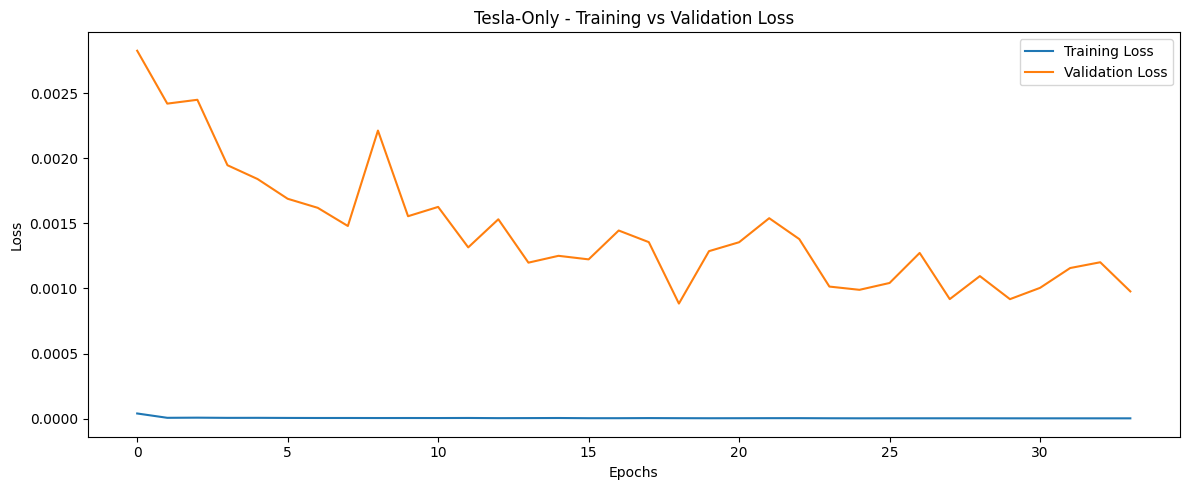


Performance for Tesla-Only:
  MSE : 147.8074
  MAE : 8.8155
  RMSE: 12.1576


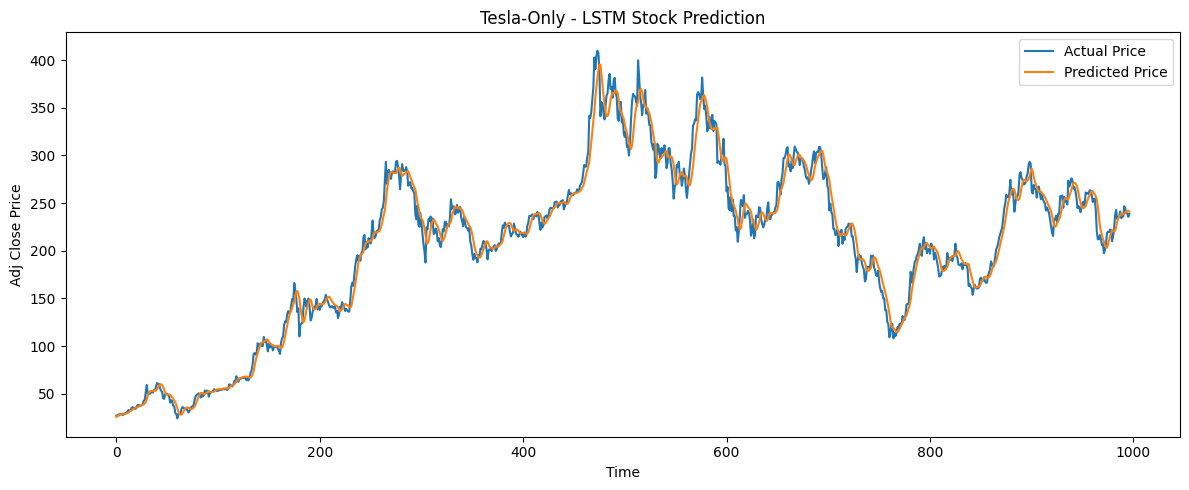

In [32]:
feature_cols = ['Close']
target_col = 'Close'
df = tesla_gold_df[feature_cols]

X_train, X_test, y_train, y_test, scaler, target_index = preprocess_data(df, feature_cols, target_col, look_back=60, test_ratio=0.3)
mse, mae, rmse = train_and_evaluate_LSTM(X_train, X_test, y_train, y_test, scaler, target_index, epochs=50, label="Tesla-Only")
results_tesla_only = {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

## LSTM with Tesla + Gold

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 60, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,827 (202.45 KB)

 Trainable params: 51,827 (202.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
73/73 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 7.7841e-04 - mae: 0.0194 - val_loss: 0.1343 - val_mae: 0.3339 - learning_rate: 0.0010
Epoch 2/2
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 4.7114e-05 - mae: 0.0052 - val_loss: 0.0106 - val_mae: 0.0782 - learning_rate: 0.0010
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


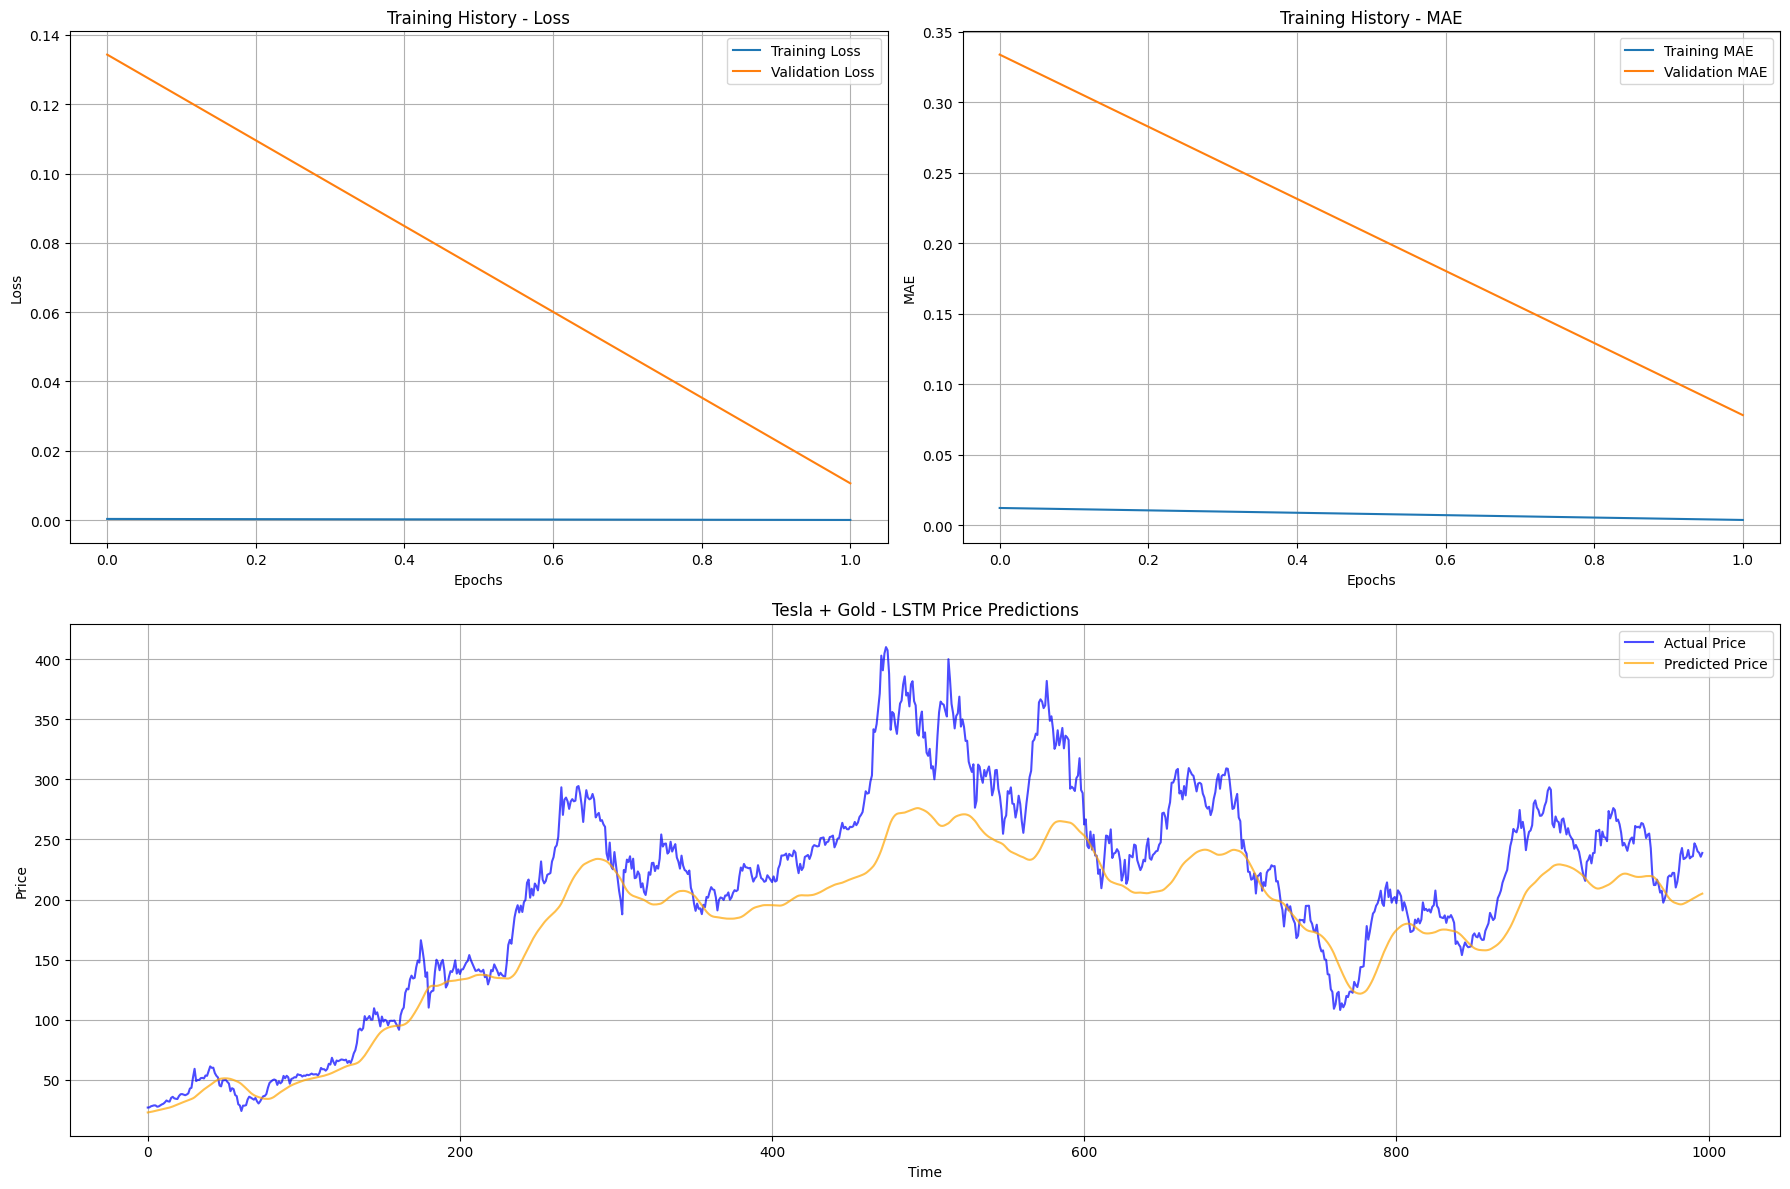


Performance Metrics for Tesla + Gold:
  MSE  : 1771.4656
  MAE  : 31.9795
  RMSE : 42.0888


In [55]:
# Choose input features and target (with an additional feature 'Gold')
feature_cols = ['Close', 'Gold']
target_col = 'Close'
df = tesla_gold_df[feature_cols]

X_train, X_test, y_train, y_test, scaler, target_index = preprocess_data(df, feature_cols, target_col, look_back=60, test_ratio=0.3)
mse, mae, rmse = train_and_evaluate_LSTM(X_train, X_test, y_train, y_test, scaler, target_index, epochs=2, label="Tesla + Gold")
results_tesla_gold = {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

In [ ]:
# Results from Tesla-only model
print("\nComparison of Tesla-only vs Tesla + Gold LSTM Models:")
print("\nTesla-only Results:")
print(f"  MSE : {results_tesla_only['MSE']:.4f}")
print(f"  MAE : {results_tesla_only['MAE']:.4f}")
print(f"  RMSE: {results_tesla_only['RMSE']:.4f}")

# Results from Tesla + Gold model
print("\nTesla + Gold Results:")
print(f"  MSE : {results_tesla_gold['MSE']:.4f}")
print(f"  MAE : {results_tesla_gold['MAE']:.4f}")
print(f"  RMSE: {results_tesla_gold['RMSE']:.4f}")

# Part 2: Prediction with Transformers

## Utility Functions

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res


def build_transformer_model(input_shape, head_size=256, num_heads=4, ff_dim=4, dropout=0.2):

    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(dropout)(x)
    x = Dense(20, activation="relu")(x)
    outputs = Dense(1, activation="linear")(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss="mean_squared_error",
        metrics=["mae"]
    )
    model.summary()
    return model


def train_and_evaluate_transformer(X_train, X_test, y_train, y_test, scaler, target_index, epochs=50, label=""):
    # Enhanced callbacks
    callbacks = [
        EarlyStopping(monitor='val_mae', patience=15, mode='min', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint(f'best_{label}_transformer.keras', save_best_only=True)
    ]

    model = build_transformer_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        head_size=64,
        num_heads=2,
        ff_dim=256,
        dropout=0.4
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Load best weights
    model = keras.models.load_model(f'best_{label}_transformer.keras')

    # Generate predictions
    pred = model.predict(X_test)

    # Inverse scaling
    pad_pred = np.zeros((len(pred), scaler.n_features_in_))
    pad_pred[:, target_index] = pred.flatten()
    predicted_prices = scaler.inverse_transform(pad_pred)[:, target_index]

    pad_true = np.zeros((len(y_test), scaler.n_features_in_))
    pad_true[:, target_index] = y_test.flatten()
    actual_prices = scaler.inverse_transform(pad_true)[:, target_index]

    # Calculate metrics
    mse = mean_squared_error(actual_prices, predicted_prices)
    mae = mean_absolute_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)

    # Enhanced plotting
    plt.figure(figsize=(18, 12))

    # Plot 1: Training History
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: MAE History
    plt.subplot(2, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training History - MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    # Plot 3: Predictions vs Actual
    plt.subplot(2, 1, 2)
    plt.plot(actual_prices, label='Actual Price', color='blue', alpha=0.7)
    plt.plot(predicted_prices, label='Predicted Price', color='orange', alpha=0.7)

    plt.title(f'{label} - Price Predictions')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\nPerformance Metrics for {label}:")
    print(f"  MSE  : {mse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  RMSE : {rmse:.4f}")

    return mse, mae, rmse

## Transformers with Tesla-only Data

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 1)     │          2 │ input_layer_20[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 1)     │        897 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_78          │ (None, 60, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 60, 1)     │          0 │ dropout_78[0][0], │
│                     │                   │            │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 1)     │          2 │ add_40[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 60, 256)   │        512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_79          │ (None, 60, 256)   │          0 │ dense_80[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 60, 1)     │        257 │ dropout_79[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_41 (Add)        │ (None, 60, 1)     │          0 │ dense_81[0][0],   │
│                     │                   │            │ add_40[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 60)        │          0 │ add_41[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_80          │ (None, 60)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 20)        │      1,220 │ dropout_80[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 1)         │         21 │ dense_82[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,911 (11.37 KB)

 Trainable params: 2,911 (11.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 9.1662e-04 - mae: 0.0219 - val_loss: 0.0242 - val_mae: 0.1228 - learning_rate: 0.0010
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 2.0029e-04 - mae: 0.0104 - val_loss: 0.0385 - val_mae: 0.1579 - learning_rate: 0.0010
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 1.2117e-04 - mae: 0.0080 - val_loss: 0.0491 - val_mae: 0.1850 - learning_rate: 0.0010
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 9.5793e-05 - mae: 0.0074 - val_loss: 0.0370 - val_mae: 0.1585 - learning_rate: 0.0010
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 7.6143e-05 - mae: 0.0066 - val_loss: 0.0379 - val_mae: 0.1626 - learning_rate: 0.0010
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 6.3714e-05 - mae: 0.0061 - val_loss: 0.0330 - val_mae: 0.1509 - learning_rate: 0.0010
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 5.1085e-05 - mae: 0.0054 - val_loss: 0.0321 - val_mae: 0.1489 - learnin

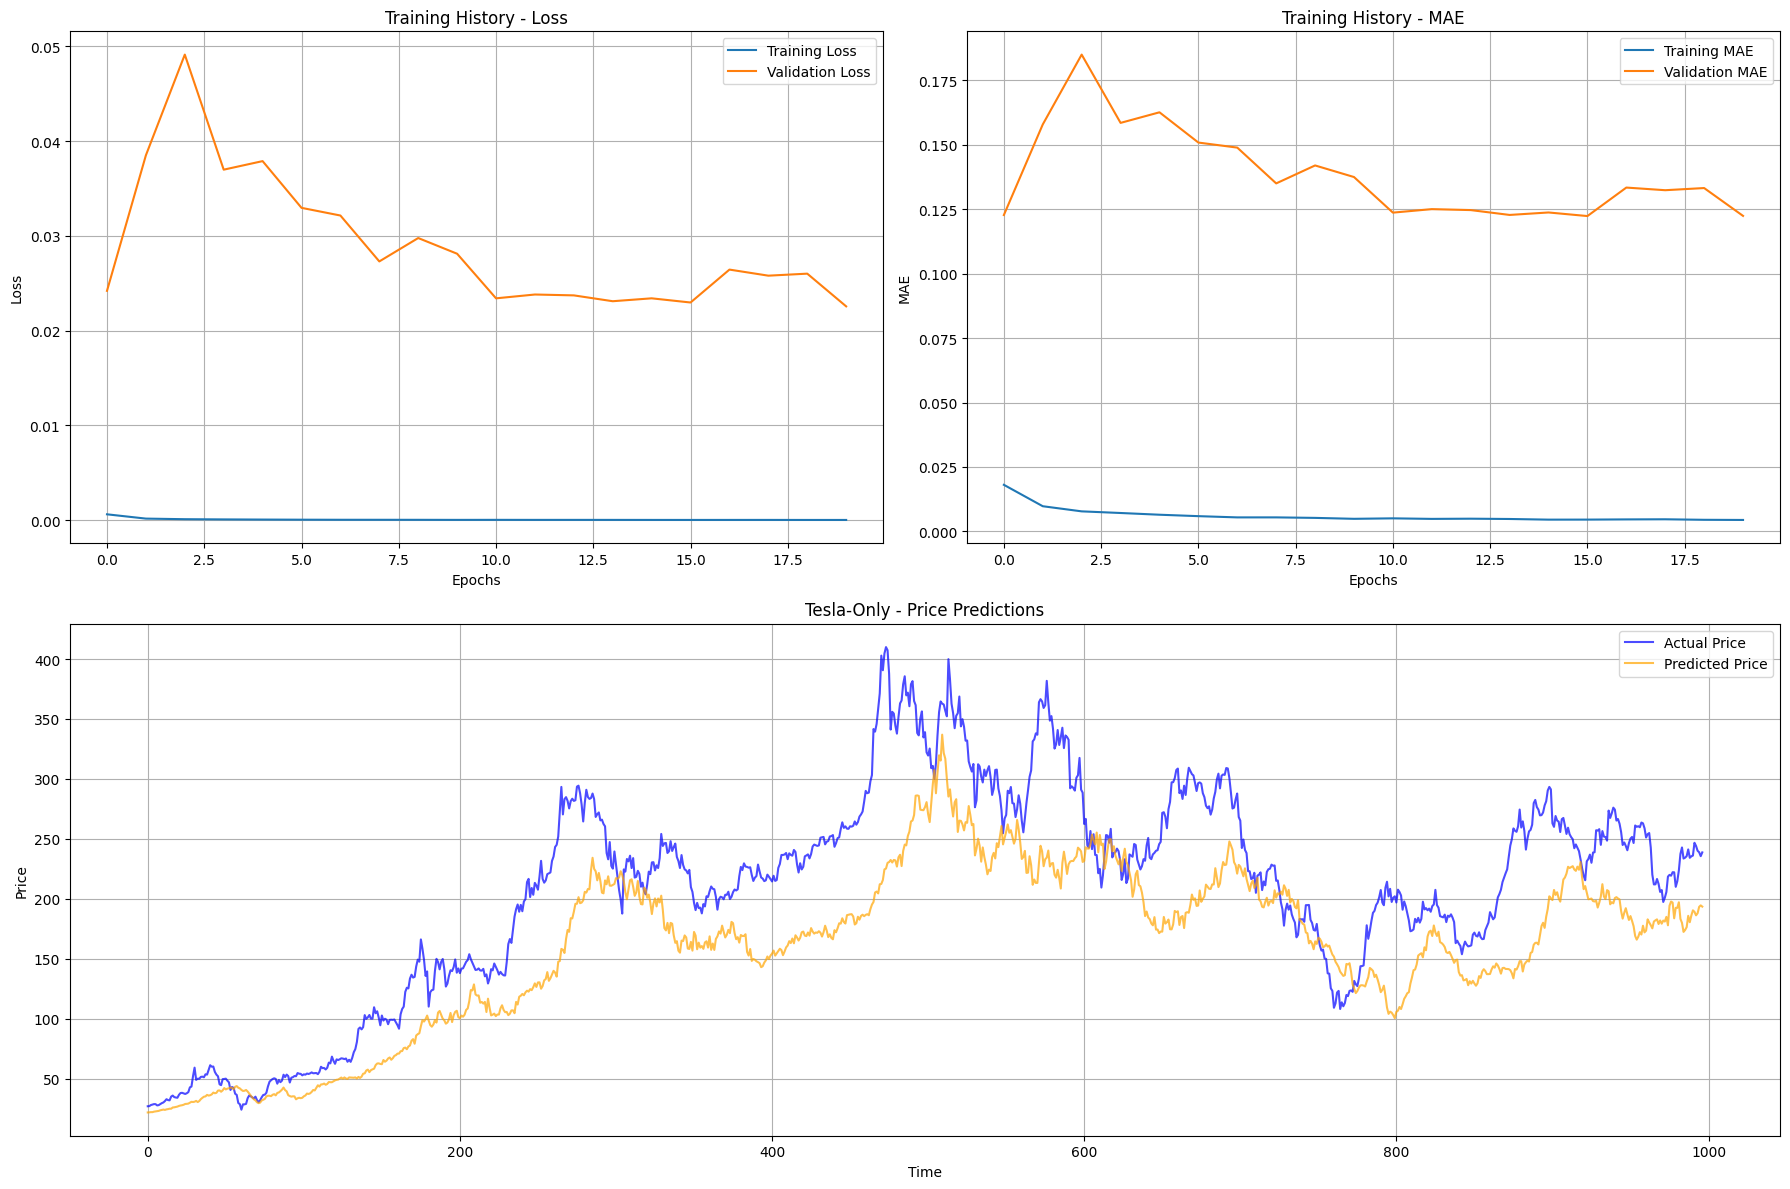


Performance Metrics for Tesla-Only:
  MSE  : 3772.6838
  MAE  : 50.0614
  RMSE : 61.4222


In [49]:
# Tesla-Only
feature_cols = ['Close']
target_col = 'Close'
df = tesla_gold_df[feature_cols]

X_train, X_test, y_train, y_test, scaler, target_index = preprocess_data(df, feature_cols, target_col, look_back=60, test_ratio=0.3)
mse, mae, rmse = train_and_evaluate_transformer(X_train, X_test, y_train, y_test, scaler, target_index, epochs=20, label="Tesla-Only")
results_tesla_only_transformer = {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

## Transformers with Tesla + Gold Data

In [ ]:
# Tesla + Gold
feature_cols = ['Close', 'Gold']
target_col = 'Close'
df = tesla_gold_df[feature_cols]

X_train, X_test, y_train, y_test, scaler, target_index = preprocess_data(df, feature_cols, target_col, look_back=60, test_ratio=0.3)
mse, mae, rmse = train_and_evaluate_transformer(X_train, X_test, y_train, y_test, scaler, target_index, epochs=50, label="Tesla + Gold")
results_tesla_gold_transformer = {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

In [ ]:
# Compare Tesla-only model performance
print("\nTesla-only Model Comparison (LSTM vs Transformer):")
print("\nLSTM Results:")
print(f"  MSE : {results_tesla_only['MSE']:.4f}")
print(f"  MAE : {results_tesla_only['MAE']:.4f}")
print(f"  RMSE: {results_tesla_only['RMSE']:.4f}")

print("\nTransformer Results:")
print(f"  MSE : {results_tesla_only_transformer['MSE']:.4f}")
print(f"  MAE : {results_tesla_only_transformer['MAE']:.4f}")
print(f"  RMSE: {results_tesla_only_transformer['RMSE']:.4f}")


# Compare Tesla + Gold model performance
print("\nTesla + Gold Model Comparison (LSTM vs Transformer):")
print("\nLSTM Results:")
print(f"  MSE : {results_tesla_gold['MSE']:.4f}")
print(f"  MAE : {results_tesla_gold['MAE']:.4f}")
print(f"  RMSE: {results_tesla_gold['RMSE']:.4f}")

print("\nTransformer Results:")
print(f"  MSE : {results_tesla_gold_transformer['MSE']:.4f}")
print(f"  MAE : {results_tesla_gold_transformer['MAE']:.4f}")
print(f"  RMSE: {results_tesla_gold_transformer['RMSE']:.4f}")


Tesla-only Model Comparison (LSTM vs Transformer):

LSTM Results:
  MSE : 359.3703
  MAE : 13.6951
  RMSE: 18.9571

Transformer Results:
  MSE : 37066.9011
  MAE : 172.8734
  RMSE: 192.5277

Tesla + Gold Model Comparison (LSTM vs Transformer):

LSTM Results:
  MSE : 652.7149
  MAE : 18.8165
  RMSE: 25.5483

Transformer Results:
  MSE : 47140.1079
  MAE : 195.6649
  RMSE: 217.1177
